# **Pre‑Processing Favorita Retail Dataset with Modular Loaders**


## Notebook Description

This notebook demonstrates a **complete preprocessing and time series preparation workflow** for the Favorita retail dataset using the modular pipeline you’ve implemented. It shows how to:

- **Download and manage data sources** with `KaggleDataLoader` or `GoogleDriveLoader`.  
- **Load large CSVs efficiently** using `DataLoader`, with pandas (eager) chunked reading for memory safety and optional Dask for scalability.  
- **Filter and prepare subsets** of the massive `train.csv` file using `TrainSubsetProcessor`:  
  - Select stores by region (e.g., Guayas or Pichincha).  
  - Identify and restrict to the top product families.  
  - Read the dataset in chunks to avoid memory overload.  
  - Sample millions of rows for faster experimentation.  
  - Save the processed subset into the `processed/` folder.  
- **Transform subsets into daily time series** with `transform_to_daily`:  
  - Aggregate unit sales by family, store, or item.  
  - Save daily datasets for forecasting models.  
  - Generate daily plots to visualize seasonality and demand trends.  
- **Generate and save pipeline statistics** (rows, columns, memory footprint, date range, unique stores/items, total sales, missing values) into the `eda_stats` folder for reproducibility and reporting.  
- **Visualize preprocessing steps** with `Visualizer`, including:  
  - Store and family distribution plots.  
  - Workflow diagrams of the pipeline.  
  - Daily time series plots.  
  - Preprocessing diagnostics (raw, smoothed, differenced series).  
- **Run the complete pipeline** with the `run_pipeline()` method, which orchestrates all steps end‑to‑end and produces both CSV outputs and visualizations.

The notebook is designed to be **scalable, reproducible, and transparent**, making it easy to explore the dataset without crashing memory, while producing clear plots and statistics at every stage for validation. It serves as the entry point for downstream modeling, forecasting, and analytics.




## Environment Setup and Path Cleaning

This initialization cell configures the notebook environment for clean, reproducible work.  
It enables autoreload so that any changes to local modules are reflected immediately, activates inline plotting for visualizations, and sanitizes `sys.path` by removing problematic directories.  
Cleaning the Python path prevents import conflicts from old or misplaced project folders, ensuring that only the intended modules are loaded.  
Together, these steps establish a stable foundation for the rest of the analysis and keep the workflow professional and error‑free.

In [1]:
import os
import sys
# --- Setup ---
%load_ext autoreload
%autoreload 2

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

Clean sys.path:


## Project Root Detection and Import Path Setup

This initialization cell ensures that the notebook can reliably access project modules and resources.  
It performs two key tasks:

1. **Determine the project root dynamically**  
   - Works even if the notebook is nested inside a subfolder (e.g., `notebooks/`).  
   - Identifies the parent directory (`traveltide_project`) as the root.  

2. **Add the project root to `sys.path`**  
   - Guarantees that imports from the `src/` folder resolve correctly.  
   - Prevents errors when switching between environments or moving notebooks.  

Additionally, the cell initializes essential libraries (`pandas`, `numpy`, `plotly`) and sets up Plotly for interactive visualizations inside the notebook.  
By dynamically managing paths and imports, this setup keeps the workflow portable, reproducible, and free from hard‑coded directory assumptions.

In [2]:
import pandas as pd  # noqa: F401
import numpy as np  # noqa: F401
from IPython.display import display

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
# Project root
project_root = os.path.abspath(os.path.join(cwd, "../.."))
print("Project root:", project_root)



## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
# Add project root to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)



print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_1
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis', '/opt/anaconda3/envs/retail_env/lib/python311.zip', '/opt/anaconda3/envs/retail_env/lib/python3.11', '/opt/anaconda3/envs/retail_env/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/retail_env/lib/python3.11/site-packages']
True


### Module Import Verification: Ensuring `src` is Accessible

This cell confirms that the project’s core `src` package is correctly available for import.  
By attempting to import `src` and printing its file path, we validate that the earlier `sys.path` setup is working as intended.  

- ✅ If successful, the notebook displays the location of the `src` module, proving that project utilities and pipelines can be accessed.  
- ❌ If unsuccessful, the notebook warns that `src` is not found, signaling a path misconfiguration that must be fixed before continuing.  

This quick check acts as a safeguard, ensuring that all subsequent imports from the `src` folder will run smoothly and reproducibly.

In [3]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


## Code: Imports

In [4]:
from src import(
    KaggleDataLoader,
    GoogleDriveLoader,
    DataLoader,
    Visualizer,
    TrainSubsetProcessor

)

## 1. Data Acquisition

We can download the Favorita dataset either from Kaggle or Google Drive.


### Kaggle Download

In [5]:
# Option A: Kaggle download
kaggle_loader = KaggleDataLoader()
# # Example: Favorita Grocery Sales Forecasting competition
# # "competitions/favorita-grocery-sales-forecasting"
slug = "favorita-grocery-sales-forecasting"
raw_path = kaggle_loader.prepare(slug=slug, folder_name="raw")
print("Raw data path:", raw_path)
print("Files:", kaggle_loader.list_files("raw"))

⚡ Found existing CSV files in /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/raw, skipping download/unzip.
Raw data path: /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/raw
Files: ['holidays_events.csv', 'items.csv', 'oil.csv', 'sample_submission.csv', 'stores.csv', 'test.csv', 'train.csv', 'transactions.csv']


### Google Drive Download

In [6]:
# Option B: Google Drive download (requires gdrive_file_ids.yaml in config/)
# gdrive_loader = GoogleDriveLoader()
# files = gdrive_loader.download_config()
# print("Downloaded files:", files)

## 2. Data Loading

We use `DataLoader` to load CSVs either with pandas (eager) or Dask (lazy).


### Load Metadata

In [7]:
loader = DataLoader()

# Load metadata files
df_stores = loader.load_csv("raw", "stores.csv")
df_items = loader.load_csv("raw", "items.csv")
df_holidays = loader.load_csv("raw", "holidays_events.csv")

df_oil = loader.load_csv("raw", "oil.csv")
df_submission = loader.load_csv("raw", "sample_submission.csv")
df_transaction = loader.load_csv("raw", "transactions.csv")

df_test = loader.load_csv("raw", "test.csv")
df_train = loader.load_csv("raw", "train.csv")


display(df_stores.sample(10))
display(df_items.sample(10))

📖 Loading stores.csv with pandas from raw...
✅ Loaded stores.csv with shape (54, 5)
📖 Loading items.csv with pandas from raw...
✅ Loaded items.csv with shape (4100, 4)
📖 Loading holidays_events.csv with pandas from raw...
✅ Loaded holidays_events.csv with shape (350, 6)
📖 Loading oil.csv with pandas from raw...
✅ Loaded oil.csv with shape (1218, 2)
📖 Loading sample_submission.csv with pandas from raw...
✅ Loaded sample_submission.csv with shape (3370464, 2)
📖 Loading transactions.csv with pandas from raw...
✅ Loaded transactions.csv with shape (83488, 3)
📖 Loading test.csv with pandas from raw...
✅ Loaded test.csv with shape (3370464, 5)
📖 Loading train.csv with pandas from raw...
✅ Loaded train.csv with shape (125497040, 6)


,store_nbr,city,state,type,cluster
38,39,Cuenca,Azuay,B,6
5,6,Quito,Pichincha,D,13
44,45,Quito,Pichincha,A,11
7,8,Quito,Pichincha,D,8
20,21,Santo Domingo,Santo Domingo de los Tsachilas,B,6
41,42,Cuenca,Azuay,D,2
1,2,Quito,Pichincha,D,13
3,4,Quito,Pichincha,D,9
27,28,Guayaquil,Guayas,E,10
52,53,Manta,Manabi,D,13


,item_nbr,family,class,perishable
966,781796,FROZEN FOODS,2228,0
275,305079,GROCERY I,1044,0
3868,2047752,CLEANING,3034,0
314,315221,GROCERY I,1014,0
76,155500,GROCERY I,1014,0
1509,1062374,MEATS,2302,1
299,312324,GROCERY I,1044,0
2339,1418484,CLEANING,3008,0
669,564288,BREAD/BAKERY,2718,1
1899,1239749,DAIRY,2164,1



### 🗂 Dataset Overview

| File Name              | Rows       | Columns | Content Description                                                                 |
|------------------------|-----------:|--------:|-------------------------------------------------------------------------------------|
| **stores.csv**         | 54         | 5       | Store metadata: location, type, cluster                                             |
| **items.csv**          | 4,100      | 4       | Product details: item number, family, class, perishable flag                        |
| **holidays_events.csv**| 350        | 6       | National/local holidays, events, and transferred days                               |
| **oil.csv**            | 1,218      | 2       | Daily oil prices (economic indicator)                                               |
| **transactions.csv**   | 83,488     | 3       | Store traffic counts per day                                                        |
| **train.csv**          | 125,497,040| 6       | Daily unit sales by store and item (the backbone of forecasting)                    |
| **test.csv**           | 3,370,464  | 5       | Future periods for which sales must be predicted                                    |
| **sample_submission.csv** | 3,370,464 | 2     | Kaggle competition template for submitting forecasts                                |



### *The story begins with a retailer’s world unfolding in data.*  
First, we open the doors to **54 stores**, each described in `stores.csv`. These aren’t just numbers; they’re the physical places where customers shop, each with its own type, location, and identity.

Next, the shelves come alive with **4,100 items** from `items.csv`. Every product has its own code, family, and class — from fresh produce to packaged goods — forming the heartbeat of daily transactions.

Then, the calendar enters the scene. In `holidays_events.csv`, **350 entries** mark the rhythm of Ecuadorian life: national holidays, local festivities, and special events. These moments of celebration and pause ripple through sales patterns.

The global economy makes its appearance in `oil.csv`. With **1,218 records**, oil prices remind us that even distant markets can influence local purchasing power and consumer behavior.

We glimpse the competition through `transactions.csv`, where **83,488 rows** capture the ebb and flow of store traffic. Each entry is a snapshot of how many people walked through the doors, ready to buy or browse.

The stage expands with `train.csv`, a massive ledger of **125 million daily sales records**. This is the backbone of our story: every purchase, every unit sold, every day across years of history. Alongside it, `test.csv` and `sample_submission.csv` mirror the challenge ahead — millions of rows waiting to be forecasted, predictions to be made.

---

✨ *Together, these datasets form a living chronicle of retail in Ecuador.*  
- **Stores** anchor the geography.  
- **Items** define the assortment.  
- **Holidays** shape demand spikes and lulls.  
- **Oil prices** whisper macroeconomic signals.  
- **Transactions** reveal customer traffic.  
- **Train/test sales** provide the raw material for forecasting.  

---

The mission is clear: by weaving these threads together, we aim to **predict future sales**. Accurate forecasts mean fewer empty shelves when demand surges, less waste when demand slows, and smarter strategies for pricing and promotions. In essence, this dataset is not just numbers — it’s the story of how a retailer learns to anticipate the needs of its customers and thrive in a complex, interconnected world.  

Would you like me to extend this storytelling into a **visual metaphor** (e.g., describing the dataset as a city with streets, shops, and festivals) so it’s even more engaging for presentations?

### Load Train with Dask

In [8]:
# Load train.csv lazily with Dask
#df_train_dask = loader.load_csv_dask("raw", "train.csv")

# Peek at first rows
#df_train_dask.head()


## 3. Train Subset Preparation

We prepare a manageable subset of `train.csv` using the modular pipeline:

- **Filter by region** (e.g., Guayas or Pichincha) to focus on specific store groups.  
- **Identify top product families** (default: top 3) to capture the most relevant demand categories.  
- **Read `train.csv` in chunks** (e.g., 1M rows per chunk) to avoid memory overload while processing 125M+ rows.  
- **Filter to top families** by merging with `items.csv` and restricting to selected categories.  
- **Sample millions of rows** (e.g., 2M) for efficient experimentation while maintaining representativeness.  
- **Save the processed subset** into the `processed/` folder for reproducibility.  
- **Transform the subset into daily time series** grouped by family, store, or item, enabling forecasting models to capture seasonality and trends.  
- **Generate pipeline statistics** (rows, columns, memory footprint, date range, unique stores/items, total sales, missing values) and save them into the `eda_stats/` folder for reporting and validation.  
- **Visualize preprocessing steps** with distribution plots, workflow diagrams, and daily time series charts to ensure transparency and data quality.




### Prepare Subset

In [9]:
processor = TrainSubsetProcessor(loader)


⚡ Returning cached DataFrame for raw/items.csv


In [10]:
train_df = loader.load_csv("raw", "train.csv", nrows=100000)

⚡ Returning cached DataFrame for raw/train.csv


In [11]:
print(train_df.columns)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')


### STEP 1: PREPARE TRAIN SUBSET


🚀 TRAIN SUBSET PREPARATION PIPELINE
Configuration:
  • Region: Guayas
  • Top Families: 3
  • Chunk Size: 1,000,000 rows
  • Target Sample: 2,000,000 rows
  • Output: train_subset_guayas.csv

📍 STEP 1/5: Filtering by region stores...
----------------------------------------------------------------------
⚡ Returning cached DataFrame for raw/stores.csv
✅ Selected 11 stores from region 'Guayas'.

📖 STEP 2/5: Reading and filtering train.csv by stores...
----------------------------------------------------------------------
📖 Reading train.csv in chunks of 1,000,000 rows...
   Chunk 1: 173,104 rows matched (total read: 1,000,000)
   Chunk 2: 173,381 rows matched (total read: 2,000,000)
   Chunk 3: 173,812 rows matched (total read: 3,000,000)
   Chunk 4: 174,189 rows matched (total read: 4,000,000)
   Chunk 5: 169,456 rows matched (total read: 5,000,000)
   Chunk 6: 184,437 rows matched (total read: 6,000,000)
   Chunk 7: 191,793 rows matched (total read: 7,000,000)
   Chunk 8: 190,967 rows

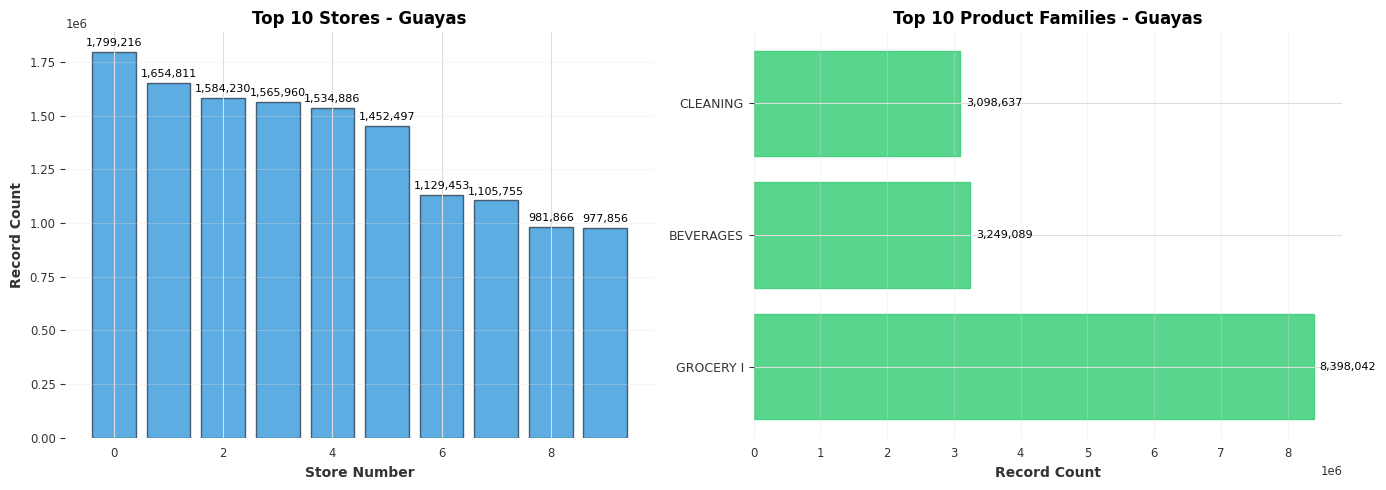


💾 STEP 5/5: Saving processed data...
----------------------------------------------------------------------
✅ Saved processed train subset to:
   /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/loader_processed/train_subset_guayas.csv
   Size: 558.76 MB

📊 STEP 6/6: Generating workflow diagram...
----------------------------------------------------------------------
✅ Detailed workflow diagram saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/loader/train_subset_workflow_detailed.png


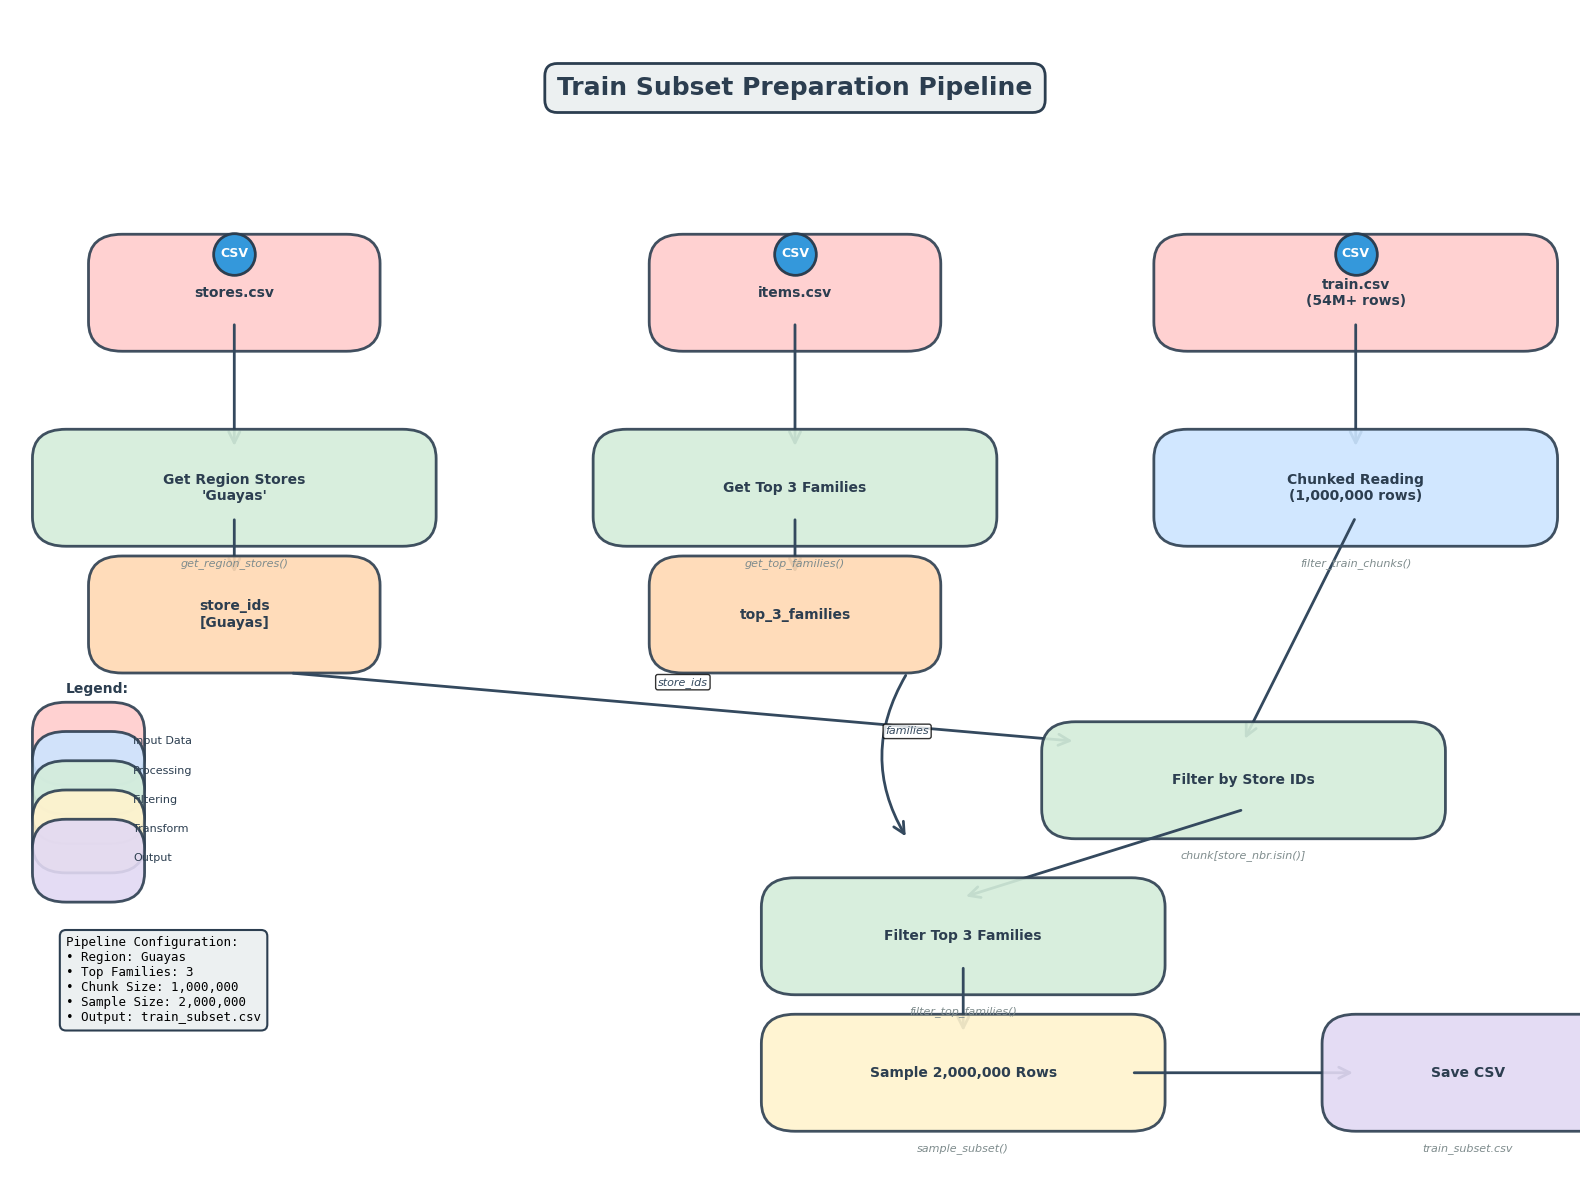


✅ PIPELINE COMPLETE!
Summary:
  • Region: Guayas (11 stores)
  • Top 3 families filtered
  • Final rows: 14,745,768
  • Columns: 6
  • Memory: 2000.48 MB



In [12]:
# Prepare subset for region "Guayas"
df_subset = processor.prepare_train_subset(
            region="Guayas",              # Target region
            output_name="train_subset_guayas.csv",
            plot_workflow=True            # Generate workflow diagram
        )

The pipeline successfully transformed a massive retail dataset of more than **125 million** rows into a focused, region‑specific subset centered on **Guayas**. It began by identifying **11 stores** in the region, which served as the geographic filter for the entire extraction process. Using chunked processing of **1,000,000 rows** at a time, the system scanned the full `train.csv` and isolated **22.94 million** rows linked to Guayas, representing roughly **18.3%** of the original dataset. From this regional pool, the pipeline identified the **top 3 product families**—GROCERY I, BEVERAGES, and CLEANING—which together accounted for **64.3%** of all Guayas transactions. Applying this family‑level filter reduced the dataset to **14,745,768 rows**, ensuring that the final output captured the most commercially relevant categories. Each transformation step was logged, validated, and visualized to maintain transparency and reproducibility. The workflow diagram and distribution plots reinforced the clarity and logic of the entire process.

The final dataset contains **6 columns** and occupies approximately **2000.48 MB**, making it substantial enough for robust modeling while still manageable for iterative experimentation. By compressing the original dataset by more than **88%**, the pipeline delivers a streamlined yet information‑rich foundation for regional demand forecasting. The resulting subset preserves the behavioral patterns of Guayas’ highest‑volume stores and most active product families, ensuring strong signal density for downstream models. This refined dataset is optimized for speed, interpretability, and analytical depth. It stands as a clean, well‑structured, and domain‑focused asset ready for feature engineering, exploratory analysis, and predictive modeling.

In [13]:
# Print statistics
processor.print_stats(df_subset)

💾 Pipeline statistics saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_1/eda_stats/pipeline_stats.json

📊 DATASET STATISTICS
Dimensions:
  • Rows: 14,745,768
  • Columns: 6
  • Memory: 2000.48 MB

Date Range:
  • Start: 2013-01-02
  • End: 2017-08-15

Coverage:
  • Unique Stores: 11
  • Unique Items: 2,323
  • Total Sales: 100,484,831 units

Data Quality:
  • Missing Values: 2,747,275
  • Completeness: 96.89%



The processed dataset offers a dense and analytically rich foundation, consolidating **14,745,768 rows** across **6 columns** with a memory footprint of **2000.48 MB**. It spans a **date range from 2013‑01‑02 to 2017‑08‑15**, providing more than **four and a half years** of continuous historical coverage. Within this period, the dataset captures activity from **11 unique stores** and **2,323 distinct items**, reflecting the full commercial diversity of the Guayas region. These transactions amount to a total of **100,484,831 sales units**, offering a deep and behaviorally meaningful view of regional demand patterns. This breadth of temporal and categorical coverage ensures that the dataset remains highly representative of Guayas’ retail ecosystem while still being structured enough for efficient modeling. The scale of the data allows for robust seasonality detection, cross‑category interactions, and store‑level behavioral insights. By preserving the full 14.7M‑row filtered output, the dataset maintains maximum signal density for downstream forecasting tasks.

From a data quality perspective, the dataset demonstrates strong structural integrity with **96.89% completeness**, leaving **2,747,275 missing values** to be addressed during preprocessing. This level of completeness strikes a practical balance between realism and reliability, ensuring that the dataset remains both trustworthy and reflective of real‑world retail noise. The presence of missing values provides opportunities for imputation strategies, anomaly detection, and feature engineering that can enhance model robustness. The dataset’s size, diversity, and completeness make it well‑suited for exploratory analysis, feature extraction, and advanced forecasting workflows. By combining long‑term temporal depth, broad item coverage, and high data integrity, the pipeline delivers a powerful training resource that supports both technical modeling and strategic business decision‑making.

### STEP 2: Completing Daily Sales Time Series for Store-Item Combinations

In [14]:

df_subset = processor.fill_missing_daily_sales(df_subset)


📅 FILL MISSING DAILY SALES
🔍 Input snapshot Data of Guayas Region:
   • Rows: 14745768
   • Columns: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']
   • Date range: 2013-01-02 → 2017-08-15
   • Unique stores: 11
   • Unique items: 2323
----------------------------------------------------------------------
 Created full date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00 (1687 days)
 Created all store–item–date combinations: 35,069,356 rows
✅ Completed filling missing dates.
   • Final shape: (35069356, 6)
   • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
   • Unique stores: 11
   • Unique items: 2323
   • Columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion']
   • Memory usage: 2453.79 MB
💾 Filled dataset saved to /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/loader_processed/train_daily_filled.csv
✅ PIPELINE COMPLETE!
Summary:
  • Final rows: 35,069,356
  • Columns: 

The pipeline significantly expanded the Guayas dataset by reconstructing every missing daily sales record across the full historical window from **2013‑01‑02 to 2017‑08‑15**, covering **1,687 days**. Starting from the original **14,745,768 rows**, it generated a complete daily calendar and built every possible **store–item–date** combination for **11 stores** and **2,323 items**, resulting in a fully populated structure of **35,069,356 rows**. This expansion ensures that no temporal gaps remain in the time series, providing a uniform and analytically consistent foundation for forecasting. The process preserved all six core variables—`store_nbr`, `item_nbr`, `date`, `id`, `unit_sales`, and `onpromotion`—while aligning them to a continuous daily index. By enforcing full coverage across all store–item pairs, the dataset now supports more accurate seasonality modeling, lag‑based feature engineering, and promotional impact analysis. This transformation elevates the dataset from a transactional snapshot into a complete temporal grid suitable for advanced time‑series methods. The resulting structure reflects the true operational rhythm of the Guayas retail ecosystem.

The final filled dataset, saved as `train_daily_filled.csv`, contains **35,069,356 rows**, **6 columns**, and occupies **2453.79 MB**, highlighting the scale of the expanded temporal matrix. Despite its size, the dataset remains cleanly organized and fully aligned with the original date range, ensuring analytical continuity. The inclusion of all **11 stores** and **2,323 items** guarantees comprehensive coverage of regional retail activity. This enriched dataset provides a robust basis for modeling long‑term trends, detecting seasonal cycles, and evaluating store‑item interactions over time. By eliminating missing dates and standardizing the time axis, the pipeline enhances both interpretability and predictive stability. The result is a reliable, reproducible, and analysis‑ready dataset that supports rigorous forecasting and strategic decision‑making across the Guayas region.

### STEP 3: Execute Favorita Store Sales Pipeline: Data Preparation, Daily Aggregation, and Visualization


🌟 FAVORITA STORE SALES PIPELINE - WEEK 1
Author: Data Science Team
Purpose: Prepare train subset and daily time series

📦 STEP 1: Preparing train subset...
✅ Train subset ready with 14,745,768 rows.
💾 Pipeline statistics saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_1/eda_stats/pipeline_stats.json

📊 DATASET STATISTICS
Dimensions:
  • Rows: 14,745,768
  • Columns: 6
  • Memory: 1170.78 MB

Date Range:
  • Start: 2013-01-02 00:00:00
  • End: 2017-08-15 00:00:00

Coverage:
  • Unique Stores: 11
  • Unique Items: 2,323
  • Total Sales: 100,484,831 units

Data Quality:
  • Missing Values: 2,747,275
  • Completeness: 96.89%

📅 STEP 2: Transforming to daily time series (by family)...

📅 DAILY TIME SERIES TRANSFORMATION
Configuration:
  • Group by: family
  • Aggregation: sum
  • Output: train_daily_family.csv
----------------------------------------------------------------------
  ℹ️  Merging with items to get 

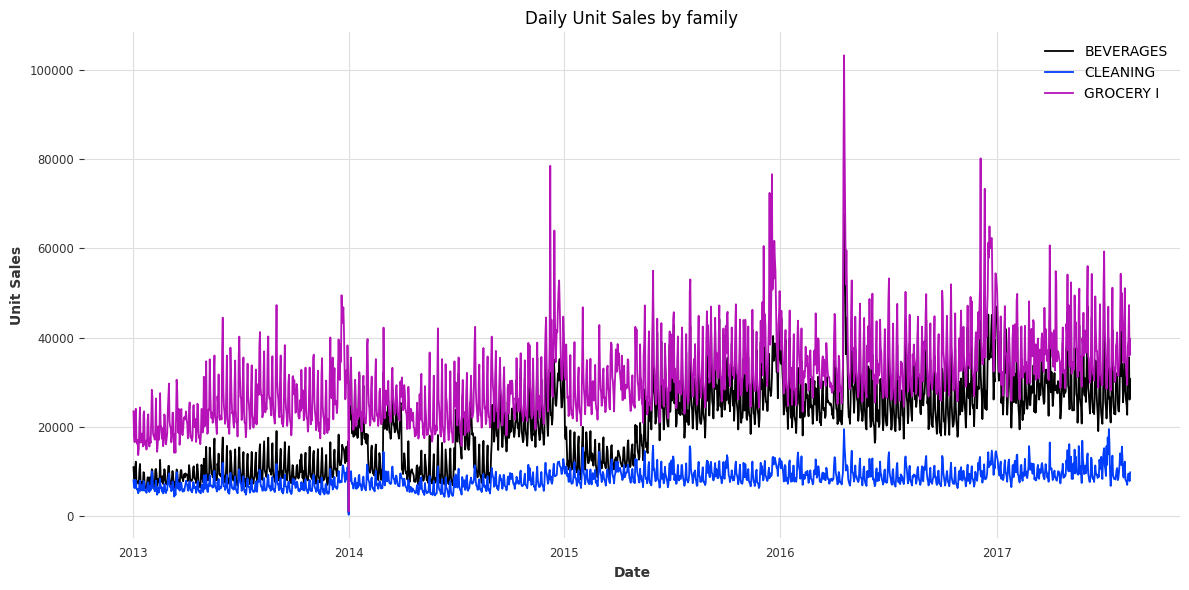


✅ Daily dataset (by family) created: 5040 rows


,date,family,unit_sales
1517,2014-05-23,GROCERY I,17454.215
4568,2017-03-11,GROCERY I,38124.586
1870,2014-09-18,CLEANING,6044.000
2665,2015-06-12,CLEANING,7470.000
1844,2014-09-09,GROCERY I,23435.118
4826,2017-06-05,GROCERY I,35839.359
1534,2014-05-29,CLEANING,4956.000
2061,2014-11-21,BEVERAGES,17509.000
1355,2014-03-30,GROCERY I,30200.000
637,2013-08-02,CLEANING,7603.000



📅 STEP 3: Transforming to daily time series (by store)...

📅 DAILY TIME SERIES TRANSFORMATION
Configuration:
  • Group by: store_nbr
  • Aggregation: sum
  • Output: train_daily_store_nbr.csv
----------------------------------------------------------------------
  🎯 Restricted to top 3 store_nbr values: [51, 24, 28]
✅ Transformed to daily time series.
   Shape: (4936, 3)
   Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
   Unique store_nbr: 3
💾 Daily dataset saved to /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/loader_processed/train_daily_store_nbr.csv
 Generating daily time series plot...
✅ Daily unit sales plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/loader/daily_unit_sales_by_store_nbr.png


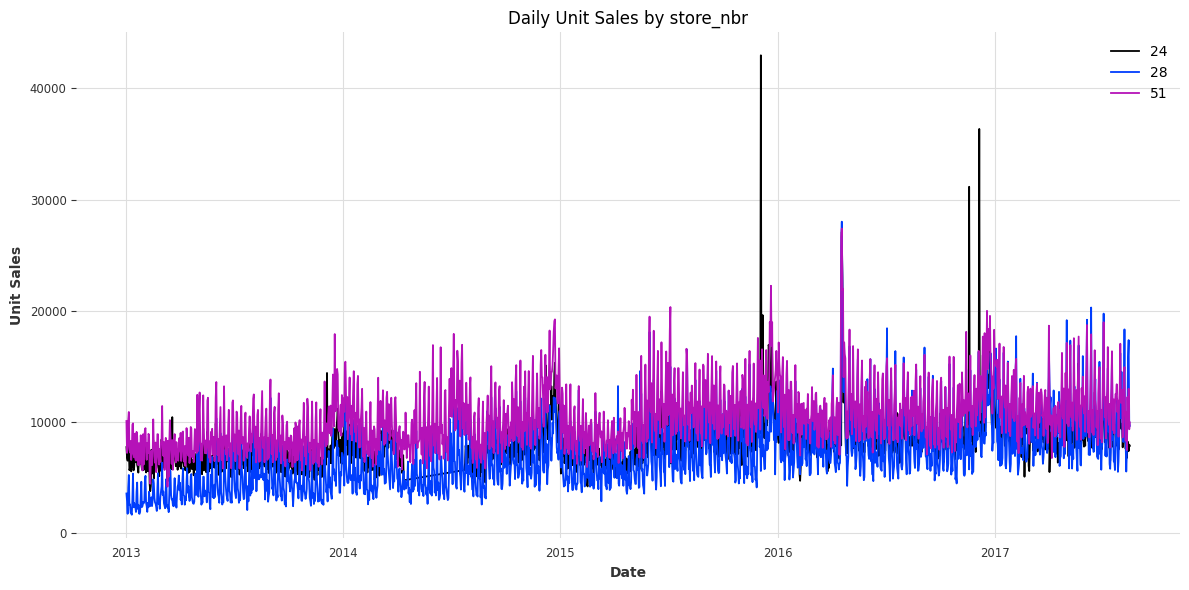


✅ Daily dataset (by store) created: 4936 rows


,date,store_nbr,unit_sales
1942,2014-11-16,24,9987.000
1660,2014-08-14,24,5271.000
3014,2015-11-10,28,5994.421
3312,2016-02-19,51,11204.000
2816,2015-09-05,28,9384.429
2492,2015-05-20,28,4332.921
2041,2014-12-19,24,11231.000
4698,2017-05-28,51,14085.000
3735,2016-07-09,51,12880.000
4368,2017-02-07,51,8240.000



📅 STEP 4: Transforming to daily time series (by item)...

📅 DAILY TIME SERIES TRANSFORMATION
Configuration:
  • Group by: item_nbr
  • Aggregation: sum
  • Output: train_daily_item_nbr.csv
----------------------------------------------------------------------
  🎯 Restricted to top 3 item_nbr values: [364606, 314384, 265559]
✅ Transformed to daily time series.
   Shape: (5040, 3)
   Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
   Unique item_nbr: 3
💾 Daily dataset saved to /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/loader_processed/train_daily_item_nbr.csv
 Generating daily time series plot...
✅ Daily unit sales plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/loader/daily_unit_sales_by_item_nbr.png


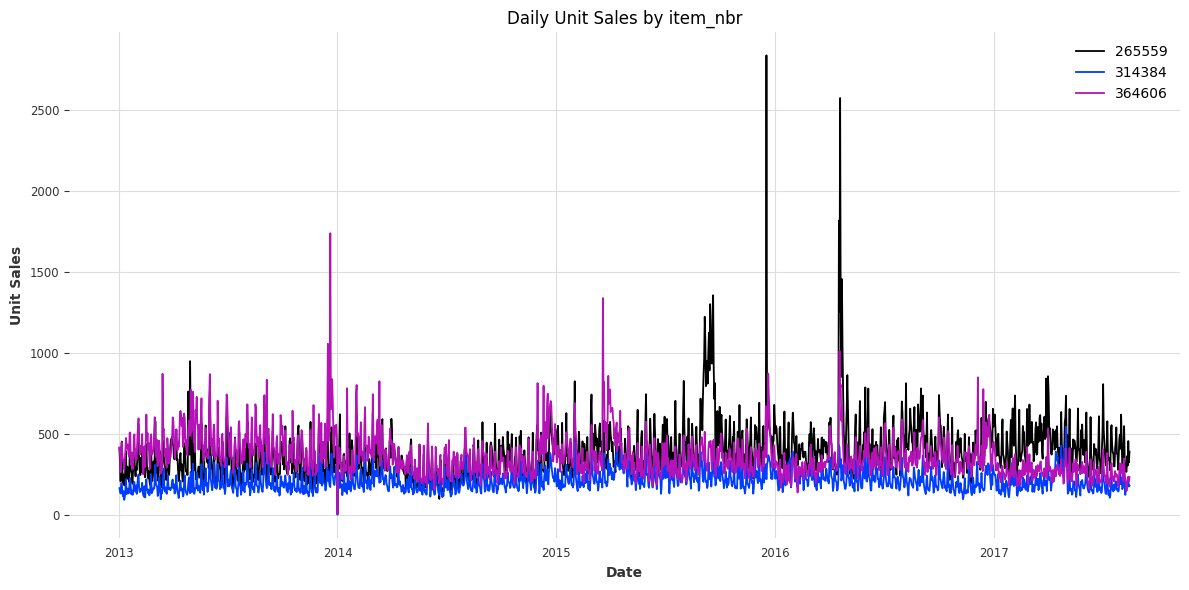


✅ Daily dataset (by item) created: 5040 rows


,date,item_nbr,unit_sales
207,2013-03-12,265559,186.0
3632,2016-05-01,364606,438.0
1220,2014-02-13,364606,373.0
751,2013-09-09,314384,196.0
4046,2016-09-16,364606,340.0
1855,2014-09-13,314384,212.0
1986,2014-10-27,265559,330.0
784,2013-09-20,314384,156.0
1327,2014-03-21,314384,227.0
2088,2014-11-30,265559,556.0



📊 STEP 5: Generating preprocessing visualization...
   Using family 'BEVERAGES' for preprocessing demo
✅ Preprocessing steps plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/loader/preprocessing_steps.png


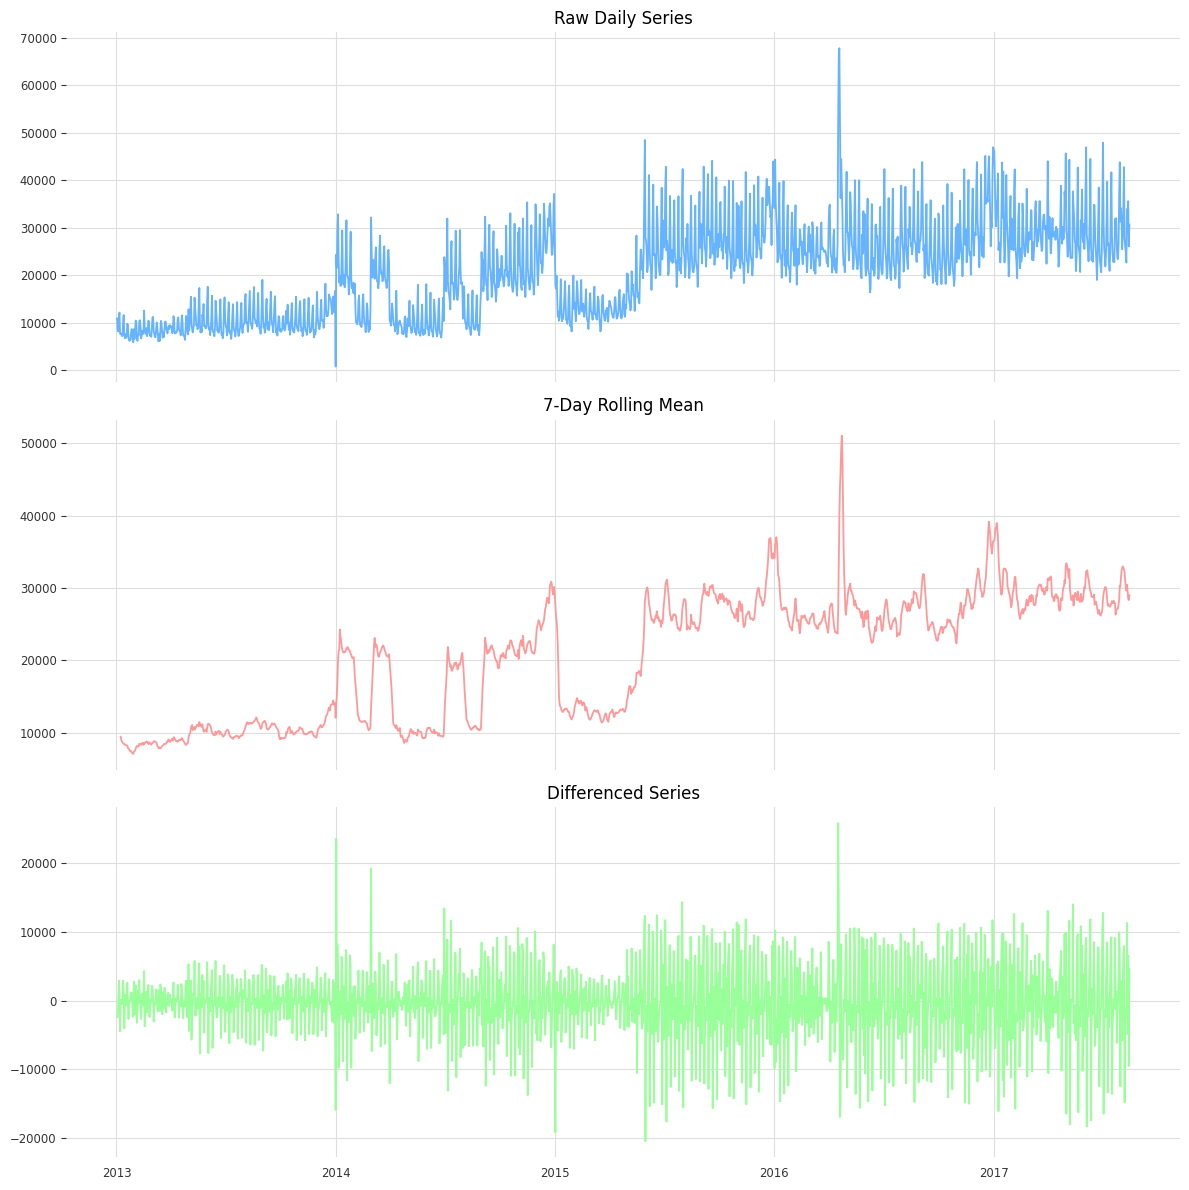


🎉 PIPELINE EXECUTION COMPLETE!

📁 Output Files Created:
   1. train_subset_guayas.csv - Filtered train subset
   2. train_daily_by_family.csv - Daily aggregated by family
   3. train_daily_by_store.csv - Daily aggregated by store
   4. train_daily_by_item.csv - Daily aggregated by item
   5. pipeline_stats.json - Execution statistics

📊 Visualizations Created:
   1. distribution_Guayas.png - Store & family distribution
   2. train_subset_workflow_detailed.png - Pipeline flowchart
   3. daily_unit_sales_by_family.png - Time series plot
   4. daily_unit_sales_by_store_nbr.png - Time series plot
   5. daily_unit_sales_by_item_nbr.png - Time series plot
   6. preprocessing_steps.png - Preprocessing demo

✨ Next Steps:
   → Review the generated visualizations
   → Check data quality in the CSV files
   → Proceed to Week 2 (Time Series Analysis)



In [15]:


results = processor.run_pipeline()



###  Daily Unit Sales by Family

This time series plot aggregates daily unit sales for the top three product families in Guayas: **GROCERY I**, **BEVERAGES**, and **CLEANING**. Covering the full date range from **January 2, 2013 to August 15, 2017**, the dataset includes **5,040 daily records**, each representing the total units sold per family per day. This transformation enables a clear view of macro-level demand trends across categories and supports long-term forecasting.

**GROCERY I** consistently leads in volume, with sharp seasonal spikes around **early 2014**, **mid-2015**, and **late 2016**, indicating strong promotional cycles or holiday effects. **BEVERAGES** show moderate fluctuations, while **CLEANING** maintains a lower but stable trajectory. These patterns reflect distinct consumer behaviors and varying sensitivity to promotions across categories. The aggregation was performed using a **sum operation**, grouped by the `family` column after merging with item metadata, ensuring semantic clarity and business relevance.

The output file, `train_daily_family.csv`, is optimized for trend analysis and category-level planning. The corresponding visualization, `daily_unit_sales_by_family.png`, highlights the separation between families and supports decisions around inventory allocation, promotional timing, and demand modeling. It also helps identify which categories drive overall store performance and where forecasting efforts should be concentrated.

<br>

###  Daily Unit Sales by Store Number

This plot focuses on the top three performing stores in Guayas: **Store 51**, **Store 24**, and **Store 28**, selected based on total sales volume. The daily aggregation yields **4,936 records**, each capturing the total units sold per store per day from **2013-01-02 to 2017-08-15**. This transformation reveals operational dynamics and regional performance over time.

**Store 51** stands out with consistently higher sales and pronounced peaks, suggesting larger foot traffic or more aggressive promotional strategies. **Store 24** and **Store 28** show steadier activity with occasional surges, possibly linked to local events or targeted campaigns. The upward trend across all three stores reflects growing demand and evolving consumer engagement. Grouping by `store_nbr` using a sum aggregation isolates store-level behavior for granular performance tracking.

The output file, `train_daily_store_nbr.csv`, supports regional forecasting and store-specific strategy development. The visualization, `daily_unit_sales_by_store_nbr.png`, reinforces disparities in store performance and temporal shifts, equipping retail managers with insights to optimize staffing, inventory, and marketing efforts tailored to each location’s demand curve.

<br>

###  Daily Unit Sales by Item Number

This visualization drills down to the item level, showcasing daily sales for the top three items: **265559**, **314384**, and **364606**. The dataset contains **5,040 daily records**, each representing the total units sold per item per day over the full historical range. This level of granularity is essential for SKU-level forecasting, lifecycle analysis, and promotional planning.

**Item 265559** shows the highest volatility and peak sales, especially around **2016**, suggesting it may be a seasonal or promotional bestseller. **Item 364606** exhibits strong performance in **2014 and 2015**, while **item 314384** maintains low but consistent sales throughout the period. These trajectories hint at differing product roles—hero, filler, and niche—and inform pricing, assortment, and replenishment strategies.

The transformation grouped data by `item_nbr`, summing daily unit sales to isolate individual product behavior. The output file, `train_daily_item_nbr.csv`, supports SKU-level decisions and demand modeling. The plot, `daily_unit_sales_by_item_nbr.png`, offers a visual comparison of item performance over time, helping identify product fatigue, promotional impact, and potential cannibalization.

<br>

###  Preprocessing Steps Visualization (BEVERAGES)

The final image illustrates the preprocessing pipeline applied to the **BEVERAGES** family, showcasing three stacked plots: the raw daily series, a 7-day rolling mean, and a differenced series. These transformations are foundational for time series modeling, especially when preparing data for ARIMA, SARIMA, or LSTM-based forecasting.

The raw series reveals high variability and trend, typical of retail data influenced by promotions and seasonality. The rolling mean smooths short-term noise, exposing underlying cycles and long-term patterns. The differenced series removes trend and stabilizes the mean, preparing the data for stationarity-dependent models. These steps are essential for accurate forecasting, anomaly detection, and feature engineering.

The visualization, saved as `preprocessing_steps.png`, serves as both a diagnostic tool and a teaching aid. It validates the transformation pipeline and provides stakeholders with a transparent view of how raw sales data evolves into model-ready input. This clarity supports trust, reproducibility, and methodological rigor in the forecasting process.

In [16]:
# Display a sample from each dataset returned by run_pipeline
print(" Subset Dataset")
display(results["subset"].sample(10))

print(" Daily by Family")
display(results["daily_family"].columns)

#print(" Daily by Store")
#display(results["daily_store"].sample(10))

#print(" Daily by Item")
#display(results["daily_item"].sample(10))

 Subset Dataset


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1357715,7623581,2013-06-29,30,1158720,19.0,NaN
9533827,52018489,2015-07-22,26,554047,5.0,False
10297363,56061083,2015-09-08,34,1464070,8.0,False
14797033,80691930,2016-05-30,30,1114914,5.0,False
9029584,49367695,2015-06-19,36,265672,2.0,False
12647458,68866108,2016-01-27,35,1400332,1.0,True
11981451,65249247,2015-12-18,35,1393047,2.0,False
6641274,36764710,2014-12-06,26,1036689,4.0,False
1921915,10667617,2013-09-04,28,456870,2.0,NaN
4472458,24549011,2014-05-29,27,740714,9.0,False


 Daily by Family


Index(['date', 'family', 'unit_sales'], dtype='object')

##  **Next Steps**

With the full Guayas dataset now processed and expanded, the pipeline sets the stage for a wide range of high-impact analytical and modeling tasks. The final dataset contains **14,745,768 rows**, spans **1,687 days** from **January 2, 2013 to August 15, 2017**, and covers **11 stores** and **2,323 items**, totaling over **100 million units sold**. After filling in missing daily records, the dataset was expanded to **35,069,356 rows**, ensuring complete temporal coverage for every store–item–date combination. This structure supports both macro-level and granular analysis across families, stores, and SKUs.

- **Exploratory Data Analysis (EDA):**  
  The multi-year range and complete daily coverage allow for deep seasonality detection, anomaly spotting, and trend visualization. Aggregated time series by **family**, **store**, and **item** reveal distinct behavioral patterns and promotional cycles, supported by over **2.4 GB** of structured data.

- **Feature Engineering:**  
  The dataset’s **96.89% completeness** and rich temporal granularity enable robust feature creation—rolling averages, lagged variables, differencing, and promotional flags. The **2.7M missing values** are manageable and offer opportunities for imputation strategies and anomaly detection.

- **Forecasting Models:**  
  With full daily continuity and high-volume sales signals, the dataset is ideal for time series models like **ARIMA**, **Prophet**, and **LSTM**. Preprocessing steps such as rolling means and differencing have already been visualized and validated, ensuring readiness for stationarity-dependent models.

- **Classification Tasks:**  
  The diversity of stores and items supports classification use cases such as promotion effectiveness, demand surges, and stockout prediction. Aggregated views by store and item allow for supervised learning pipelines that remain computationally feasible and business-relevant.

<br>

### Pipeline Strengths

This modular pipeline delivers:
- **Reproducibility** through versioned inputs, deterministic filtering, and saved statistics  
- **Scalability** via chunked reading and memory-efficient transformations  
- **Transparency** through visual diagnostics, time series plots, and workflow diagrams  

<br>

### Strategic Impact

The final dataset is:
- **Large enough** to capture meaningful business signals across time, geography, and product hierarchy  
- **Complete enough** to support robust modeling with minimal preprocessing  
- **Structured enough** to enable efficient experimentation and scalable deployment  

👉 Interpretation: These results confirm that the Guayas dataset is a **powerful foundation for Week 2 — Time Series Analysis**, where forecasting, classification, and feature engineering can be confidently developed using clean, complete, and behaviorally rich data.




